## Imports
Loading required libraries for importing

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Prepare model
Prepare model for object detection

In [104]:
MODEL_NAME = 'inference_graph'
PATH_TO_FROZEN_GRAPH = 'data/graph/frozen_inference_graph.pb'
PATH_TO_LABELS = 'data/label.pbtxt'

Load TF fronze graph to memory

In [105]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Load labels

In [106]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Function to detect

## Lets predict
Predict the image

In [115]:
def predict(image):
    global detection_graph
    global sess
    #global tensor_dict
    
    image_np = np.array(image)
    with detection_graph.as_default():
        with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)


                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                
                # Actual detection.
                if 'detection_masks' in tensor_dict:
                    print("detection is here already")
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, 
                        image_np.shape[0], 
                        image_np.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                        feed_dict={image_tensor: np.expand_dims(
                                            image_np, 0)})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = np.squeeze(output_dict['detection_scores'][0])
                if 'detection_masks' in output_dict:
                    output_dict['detection_masks'] = output_dict['detection_masks'][0]

                scores = []
                for i in output_dict['detection_scores']:
                    #if i > 0.5:
                        scores.append(i)
                    #elif i>0.01:
                    #   scores.append(0.6)
                    #else:
                    #    scores.append(0)

                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  output_dict['detection_boxes'],
                  output_dict['detection_classes'],
                  scores,
                  #output_dict['detection_scores'],
                  category_index,
                  instance_masks=output_dict.get('detection_masks_reframed', None),
                  use_normalized_coordinates=True,
                  line_thickness=1)
                display(Image.fromarray(image_np))
                #cv2.imshow('object_detection', cv2.resize(image_np, (800, 600)))

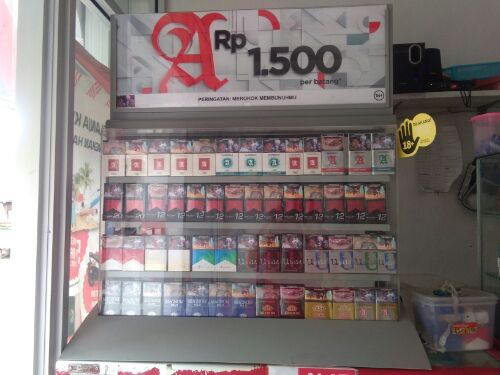

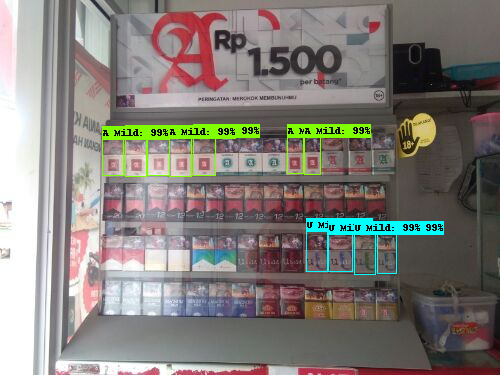

In [116]:
image_file = "images/raw/WhatsApp Image 2019-11-29 at 14.51.29-3.jpeg"
image = Image.open(image_file)
display(image)
predict(image)